## 프레임 별 감정 분석

- Author
  - cheesecat47 <cheeseecat47@gmail.com>
- References
  - https://github.com/Moddy2024/ResNet-9/blob/main/prediction.ipynb


In [29]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image as Img
import cv2
import os
import sys
from pathlib import Path
import numpy as np
import torchvision.transforms as T
from loguru import logger
from typing import Tuple
from torchvision.models import resnet18
from PIL import Image

PROJECT_BASE = str(Path(".").absolute().parent.parent)
if PROJECT_BASE not in sys.path:
    sys.path.append(PROJECT_BASE)

sys.path

['/home/ssafy/S10P22D102/api-ai/ai/ipynb',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/home/ssafy/.cache/pypoetry/virtualenvs/api-ai-a88WYcI0-py3.11/lib/python3.11/site-packages',
 '/home/ssafy/S10P22D102/api-ai']

In [30]:
DATA_HOME = os.path.join(PROJECT_BASE, "ai/data")
print(f"{DATA_HOME = }")

VIDEO_PATH = os.path.join(
    DATA_HOME, "video/admin@d102.com/2024-03-29T15-28-00/test1.mp4"
)
print(f"{VIDEO_PATH = }")

DATA_HOME = '/home/ssafy/S10P22D102/api-ai/ai/data'
VIDEO_PATH = '/home/ssafy/S10P22D102/api-ai/ai/data/video/admin@d102.com/2024-03-29T15-28-00/test1.mp4'


In [31]:
def extract_frames(path: str, msec: int = 1000) -> list:
    video = cv2.VideoCapture(path)

    frame_list = []

    success = True
    count = 0
    while success:
        video.set(cv2.CAP_PROP_POS_MSEC, count * msec)
        count += 1

        success, img = video.read()
        if not success:
            continue

        frame_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    return frame_list

In [32]:
frame_list = extract_frames(VIDEO_PATH)
print(f"{len(frame_list) = }")

len(frame_list) = 72


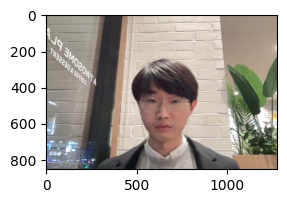

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.imshow(frame_list[0])
plt.show(fig)
plt.close(fig)

### 검출기 로딩

- haar cascade


In [34]:
classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
classifier

< cv2.CascadeClassifier 0x7fa266b8f610>

In [35]:
def detect_faces(
    img: np.ndarray,
    dsize: Tuple[int] = (224, 224),
    classifier: cv2.CascadeClassifier = None,
):
    if img is None:
        raise ValueError("img is required")
    if classifier is None:
        raise ValueError("classifier is required")

    faces = classifier.detectMultiScale(
        img, scaleFactor=1.1, minNeighbors=5, minSize=dsize
    )
    if len(faces) == 0:
        logger.debug(f"No faces are detected. Exit early.")
        return None, None, None

    img_box = img.copy()
    face_img = None
    points = None
    for x, y, w, h in faces[:1]:
        m = max(w, h)
        cv2.rectangle(img_box, (x, y), (x + m, y + m), (0, 255, 0), 2)
        face_img = cv2.resize(img_box[y: y + m, x: x + m].copy(), dsize=dsize)
        points = [x, y, m]

    return img_box, face_img, points

100%|██████████| 72/72 [00:00<00:00, 118.37it/s]


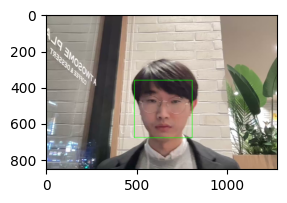

In [36]:
img_with_box_list = []
face_only_img_list = []
points_list = []

for img in tqdm(frame_list, total=len(frame_list)):
    img_box, face_img, points = detect_faces(img, (224, 224), classifier)
    img_with_box_list.append(img_box)
    face_only_img_list.append(face_img)
    points_list.append(points)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.imshow(img_with_box_list[0])
plt.show(fig)
plt.close(fig)

In [37]:
c = 7
r = len(face_only_img_list[:21]) // c

fig, axes = plt.subplots(r, c, figsize=(c, r), sharex=True, sharey=True)

i = -1
for img in face_only_img_list[:21]:
    i += 1
    if img is None:
        axes[i // c, i % c].text(24, 24, "Not detected", ha="center", va="center")
        continue

    axes[i // c, i % c].imshow(img)

# plt.show()
plt.close(fig)

## 감정 분류

- https://github.com/Moddy2024/ResNet-9/blob/main/prediction.ipynb


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [39]:
def to_device(data):
    if isinstance(data, (list, tuple)):
        return [to_device(x) for x in data]
    return data.to(device, non_blocking=True)

In [40]:
MODEL_PATH = os.path.join(
    PROJECT_BASE, "ai/models/ResNet18/resnet18_acc_0.849_2404021036.pth"
)
print(MODEL_PATH)


model = resnet18(num_classes=3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
model

/home/ssafy/S10P22D102/api-ai/ai/models/ResNet18/resnet18_acc_0.849_2404021036.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
EMOTIONS = {0: "Negative", 1: "Neutral", 2: "Positive"}


def predict(img: np.ndarray, dsize: Tuple[int] = (224, 224)):
    transform = T.Compose([T.Resize(dsize), T.ToTensor()])
    img = transform(img)

    x = to_device(img.unsqueeze(0))

    with torch.no_grad():
        y = model(x)

    _, preds = torch.max(y, dim=1)

    return EMOTIONS[preds[0].item()]

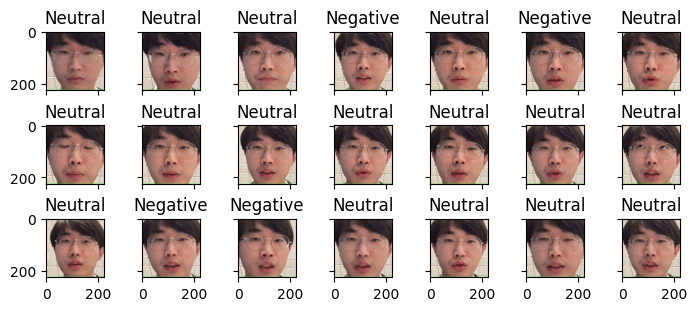

In [42]:
c = 7
r = len(face_only_img_list[:21]) // c

fig, axes = plt.subplots(
    r, c, figsize=(c, r), sharex=True, sharey=True, constrained_layout=True
)

i = -1
for img in face_only_img_list[:21]:
    i += 1
    if img is None:
        axes[i // c, i % c].text(24, 24, "Not detected",
                                 ha="center", va="center")
        continue
    axes[i // c, i % c].imshow(img)
    axes[i // c, i % c].set_title(predict(Image.fromarray(img)))

plt.show()
plt.close(fig)

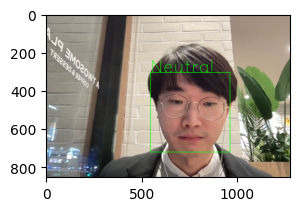

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2), constrained_layout=True)
im = ax.imshow(frame_list[0], animated=True)


def update(i):
    img = frame_list[i]
    points = points_list[i]

    if points is not None:
        (x, y, m) = points
        cv2.rectangle(img, (x, y), (x + m, y + m), (0, 255, 0), 2)
        cv2.putText(
            img,
            predict(Image.fromarray(img)),
            org=(x, y),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=3,
            color=(0, 255, 0),
            thickness=2,
        )
        cv2.resize(img, dsize=(0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    im.set_array(img)
    return (im,)


animation.FuncAnimation(
    fig, update, frames=len(frame_list), interval=250, blit=True, repeat_delay=10
).save("./out.gif", fps=4)

In [47]:
Img(url="./out.gif")